The goal of this notebook is to define traning, test and validation samples 
to implement new templates for redrock.

Some of this work is based on the code by John Moustakas:
https://github.com/moustakas/fastspecfit-projects/blob/main/redrock-templates/stack-templates#L146

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import fitsio
from astropy.table import Table, Column, hstack, vstack, join
from desiutil.log import get_logger#, DesiLogContext, WARNING
log = get_logger()

In [2]:
# The start of our parent sample is the LSS/Fuji SV3 VACs.
#lss_path = '/global/cfs/cdirs/desi/public/edr/vac/edr/lss/v2.0/LSScats/full/'
lss_path = '/global/cfs/cdirs/desi/users/ioannis/fastspecfit/redrock-templates/data/'
obj_types = ['BGS_ANY', 'ELG', 'LRG', 'QSO']
data_obj_types = {}
for obj_type in obj_types:
    filename = os.path.join(lss_path, 'lss-fuji-clustering-{}.fits'.format(obj_type))
    data_obj_types[obj_type] = fitsio.read(filename)

In [3]:
data_obj_types

{'BGS_ANY': array([(212.0693219 , -2.12738748, 39627733927462296, 2, '526-532', 0.211606  , 0.71794872, 17, 1.69306496, 1.  , [-6619185046274324457,  5644941744155000570], 0.5390625, 1., 1.84285714,  9.05734  , 15.408153, 21.32641 , 15.873154,  8.951791, 0.37905745, -0.11455412, 0.08326221, 0.06507243, 0.27399339, 0.36795281, -0.20525782, -0.10825782, -19.66851915, 0.01500877, 0.00980848),
        (212.07182231, -2.15763669, 39627733927462346, 1, '532', 0.20832115, 0.52272727, 17, 1.71934147, 0.25, [ -989607087401000204,  1761888357241395716], 0.3828125, 1., 2.58      ,  6.474439 , 16.908474, 31.81137 , 29.158867, 23.750439, 0.78568303,  0.00860345, 0.26517582, 0.23774067, 0.5980229 , 0.68197316, -0.20207152, -0.10507152, -19.85455668, 0.01528615, 0.00963221),
        (212.11374994, -2.18257701, 39627733927463205, 1, '532', 0.2731814 , 0.52272727, 17, 1.72487145, 1.  , [                  -1,                   -1], 1.       , 1., 1.        ,  4.68452  ,  8.546944, 13.930914, 18.279089, 

In [4]:
# read the vi files
# https://github.com/moustakas/fastspecfit-projects/blob/main/redrock-templates/stack-templates#L158C1-L182C17
def read_vi(vi_spectype=None, quality=2.5):
    # see https://data.desi.lbl.gov/doc/releases/edr/vac/vi/
    from glob import glob
    #vifiles = glob('/global/cfs/cdirs/desi/public/edr/vac/edr/vi/v1.0/*.csv')
    allvi = []
    for targ in ['BGS', 'LRG', 'ELG', 'QSO']:
        vifile = f'/global/cfs/cdirs/desi/public/edr/vac/edr/vi/v1.0/EDR_VI_{targ}_v1.csv'
        vi = Table.read(vifile)
        vi['SUFFIX'] = targ # os.path.basename(vifile).replace('EDR_VI_', '').replace('_v1.csv', '')
        allvi.append(vi)
    allvi = vstack(allvi)
    I = np.where(allvi['VI_QUALITY'] >= quality)[0]
    log.info(f'Trimming to {len(I):,d}/{len(allvi):,d} VI redshifts.')
    allvi = allvi[I]

    _, uindx = np.unique(allvi['TARGETID'], return_index=True)
    log.info(f'Trimming to {len(uindx):,d}/{len(allvi):,d} unique targets.')
    allvi = allvi[uindx]

    if vi_spectype:
        I = allvi['VI_SPECTYPE'] == vi_spectype
        log.info(f'Trimming to {np.sum(I):,d}/{len(allvi):,d} objects with VI_SPECTYPE={vi_spectype}.')
        allvi = allvi[I]
    
    return allvi

In [5]:
all_vi = read_vi()
assert np.unique(all_vi["TARGETID"]).size == len(all_vi)

INFO:272848714.py:15:read_vi: Trimming to 17,275/20,373 VI redshifts.
INFO:272848714.py:19:read_vi: Trimming to 17,083/17,275 unique targets.


In [6]:
all_vi

TARGETID,TILEID,FIBER,TARGET_RA,TARGET_DEC,VI_Z,VI_QUALITY,VI_SPECTYPE,SUFFIX
int64,int64,int64,float64,float64,float64,float64,str6,str3
39627634551824898,80605,398,36.18946453136912,-6.149115843122294,0.355,4.0,GALAXY,LRG
39627634556011094,80605,363,36.21608882431832,-6.128186295203432,1.394,3.0,QSO,QSO
39627634556012263,80605,397,36.24615239723666,-6.138445768391183,1.5468,4.0,QSO,QSO
39627634556014086,80605,353,36.291054274191865,-6.127697503907206,0.6555,4.0,GALAXY,LRG
39627634556014615,80605,478,36.304035269010576,-6.177153479731488,1.3637,3.0,QSO,QSO
39627634556015764,80605,191,36.33448600336392,-6.150640067188368,0.7977,4.0,GALAXY,LRG
39627634556017139,80605,495,36.3744308172597,-6.156238417732969,2.4982,3.0,QSO,LRG
39627634556018800,80605,485,36.41882485753472,-6.197608931100611,0.6995,3.5,GALAXY,LRG
39627634556019665,80605,491,36.44302732645025,-6.136826390991546,0.97,3.5,GALAXY,LRG


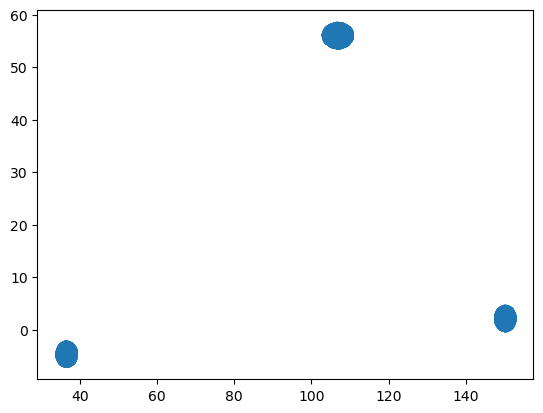

In [7]:
plt.scatter(all_vi['TARGET_RA'], all_vi['TARGET_DEC'])

In [8]:
set

set

In [9]:
tiles_edr = Table.read('/global/cfs/cdirs/desi/public/edr/spectro/redux/fuji/tiles-fuji.fits')

In [10]:
tiles_edr

TILEID,SURVEY,PROGRAM,FAPRGRM,FAFLAVOR,NEXP,EXPTIME,TILERA,TILEDEC,EFFTIME_ETC,EFFTIME_SPEC,EFFTIME_GFA,GOALTIME,OBSSTATUS,LRG_EFFTIME_DARK,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GOALTYPE,MINTFRAC,LASTNIGHT
int32,bytes20,bytes6,bytes20,bytes20,int64,float64,float64,float64,float64,float64,float64,float64,bytes20,float64,float64,float64,float64,bytes20,float64,int32
80615,cmx,other,m33,cmxm33,4,3600.1,24.027,31.39,0.0,3390.9,0.0,1000.0,obsend,3361.7,3390.9,3320.2,3878.6,other,0.9,20201216
80609,sv1,dark,lrgqso,cmxlrgqso,15,13500.7,150.12,2.206,0.0,7828.3,0.0,4000.0,obsstart,7847.0,7828.3,8057.3,10707.3,dark,0.9,20201217
80607,sv1,dark,lrgqso,cmxlrgqso,15,13500.8,106.74,56.1,0.0,9374.2,0.0,4000.0,obsstart,8794.6,9374.2,8553.9,8541.1,dark,0.9,20201219
80606,sv1,dark,elg,cmxelg,12,10800.7,36.448,-4.501,0.0,6699.4,0.0,4000.0,obsstart,6555.6,6699.4,6583.6,7397.5,dark,0.9,20201219
80620,sv1,dark,lrgqso,sv1lrgqso,9,8100.5,144.0,65.0,0.0,7128.7,0.0,4000.0,obsstart,6643.9,7128.7,6299.8,6316.1,dark,0.9,20201221
80622,sv1,dark,lrgqso,sv1lrgqso,6,5400.3,155.0,32.325,0.0,4916.9,0.0,4000.0,obsstart,4772.1,4916.9,4739.8,6935.4,dark,0.9,20201221
80623,sv1,dark,elg,sv1elg,8,7200.4,155.0,32.425,0.0,4969.7,0.0,4000.0,obsstart,4903.1,4969.7,4916.9,7266.2,dark,0.9,20201221
80611,sv1,bright,bgsmws,sv1bgsmws,12,3600.9,35.22,30.3,0.0,669.2,0.0,600.0,obsstart,641.1,723.7,669.2,407.7,bright,0.9,20201222
80617,sv1,bright,bgsmws,sv1bgsmws,16,4801.0,5.0,28.0,0.0,1309.5,0.0,600.0,obsstart,1251.7,1369.7,1309.5,884.1,bright,0.9,20201223


In [11]:
tiles_sv = tiles_edr[((tiles_edr['SURVEY']=='sv3')|(tiles_edr['SURVEY']=='sv1'))&(tiles_edr['PROGRAM']!='backup')]
tiles_sv['RA'], tiles_sv['DEC'] = tiles_sv['TILERA'], tiles_sv['TILEDEC']

In [12]:
tiles_sv

TILEID,SURVEY,PROGRAM,FAPRGRM,FAFLAVOR,NEXP,EXPTIME,TILERA,TILEDEC,EFFTIME_ETC,EFFTIME_SPEC,EFFTIME_GFA,GOALTIME,OBSSTATUS,LRG_EFFTIME_DARK,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GOALTYPE,MINTFRAC,LASTNIGHT,RA,DEC
int32,bytes20,bytes6,bytes20,bytes20,int64,float64,float64,float64,float64,float64,float64,float64,bytes20,float64,float64,float64,float64,bytes20,float64,int32,float64,float64
80609,sv1,dark,lrgqso,cmxlrgqso,15,13500.7,150.12,2.206,0.0,7828.3,0.0,4000.0,obsstart,7847.0,7828.3,8057.3,10707.3,dark,0.9,20201217,150.12,2.206
80607,sv1,dark,lrgqso,cmxlrgqso,15,13500.8,106.74,56.1,0.0,9374.2,0.0,4000.0,obsstart,8794.6,9374.2,8553.9,8541.1,dark,0.9,20201219,106.74,56.1
80606,sv1,dark,elg,cmxelg,12,10800.7,36.448,-4.501,0.0,6699.4,0.0,4000.0,obsstart,6555.6,6699.4,6583.6,7397.5,dark,0.9,20201219,36.448,-4.501
80620,sv1,dark,lrgqso,sv1lrgqso,9,8100.5,144.0,65.0,0.0,7128.7,0.0,4000.0,obsstart,6643.9,7128.7,6299.8,6316.1,dark,0.9,20201221,144.0,65.0
80622,sv1,dark,lrgqso,sv1lrgqso,6,5400.3,155.0,32.325,0.0,4916.9,0.0,4000.0,obsstart,4772.1,4916.9,4739.8,6935.4,dark,0.9,20201221,155.0,32.325
80623,sv1,dark,elg,sv1elg,8,7200.4,155.0,32.425,0.0,4969.7,0.0,4000.0,obsstart,4903.1,4969.7,4916.9,7266.2,dark,0.9,20201221,155.0,32.425
80611,sv1,bright,bgsmws,sv1bgsmws,12,3600.9,35.22,30.3,0.0,669.2,0.0,600.0,obsstart,641.1,723.7,669.2,407.7,bright,0.9,20201222,35.22,30.3
80617,sv1,bright,bgsmws,sv1bgsmws,16,4801.0,5.0,28.0,0.0,1309.5,0.0,600.0,obsstart,1251.7,1369.7,1309.5,884.1,bright,0.9,20201223,5.0,28.0
80608,sv1,dark,elg,cmxelg,23,20701.4,106.74,56.2,0.0,15166.0,0.0,4000.0,obsstart,14236.7,15166.0,13797.6,14267.9,dark,0.9,20201223,106.74,56.2


In [14]:
tileid_vi = list(set(all_vi["TILEID"]))
tilera_vi = []
tiledec_vi = []
for tileid in tileid_vi:
    ii = tiles_edr['TILEID']==tileid
    tilera_vi.append(float(tiles_edr['TILERA'][ii]))
    tiledec_vi.append(float(tiles_edr['TILEDEC'][ii]))
    print(np.count_nonzero(ii))
    

1
1
1
1
1
1
1
1


In [15]:
tiles_vi = Table()
tiles_vi["TILEID"], tiles_vi["RA"], tiles_vi["DEC"] = tileid_vi, tilera_vi, tiledec_vi

In [16]:
tiles_vi

TILEID,RA,DEC
int64,float64,float64
80608,106.74,56.2
80609,150.12,2.206
80610,150.12,2.306
80613,106.74,56.1
80670,38.0,-2.8
80605,36.448,-4.601
80606,36.448,-4.501
80607,106.74,56.1


In [17]:
tiles_sv[np.isin(tiles_sv['TILEID'], tiles_vi['TILEID'])]

TILEID,SURVEY,PROGRAM,FAPRGRM,FAFLAVOR,NEXP,EXPTIME,TILERA,TILEDEC,EFFTIME_ETC,EFFTIME_SPEC,EFFTIME_GFA,GOALTIME,OBSSTATUS,LRG_EFFTIME_DARK,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GOALTYPE,MINTFRAC,LASTNIGHT,RA,DEC
int32,bytes20,bytes6,bytes20,bytes20,int64,float64,float64,float64,float64,float64,float64,float64,bytes20,float64,float64,float64,float64,bytes20,float64,int32,float64,float64
80609,sv1,dark,lrgqso,cmxlrgqso,15,13500.7,150.12,2.206,0.0,7828.3,0.0,4000.0,obsstart,7847.0,7828.3,8057.3,10707.3,dark,0.9,20201217,150.12,2.206
80607,sv1,dark,lrgqso,cmxlrgqso,15,13500.8,106.74,56.1,0.0,9374.2,0.0,4000.0,obsstart,8794.6,9374.2,8553.9,8541.1,dark,0.9,20201219,106.74,56.1
80606,sv1,dark,elg,cmxelg,12,10800.7,36.448,-4.501,0.0,6699.4,0.0,4000.0,obsstart,6555.6,6699.4,6583.6,7397.5,dark,0.9,20201219,36.448,-4.501
80608,sv1,dark,elg,cmxelg,23,20701.4,106.74,56.2,0.0,15166.0,0.0,4000.0,obsstart,14236.7,15166.0,13797.6,14267.9,dark,0.9,20201223,106.74,56.2
80670,sv1,dark,lrgqso,sv1lrgqso,6,5327.9,38.0,-2.8,0.0,1904.8,0.0,4000.0,obsstart,1827.9,1904.8,1858.2,1721.0,dark,0.9,20210111,38.0,-2.8
80605,sv1,dark,lrgqso,cmxlrgqso,24,19559.1,36.448,-4.601,0.0,6872.9,0.0,4000.0,obsstart,6711.4,6872.9,6890.6,6824.3,dark,0.9,20210205,36.448,-4.601
80610,sv1,dark,elg,cmxelg,16,13955.7,150.12,2.306,0.0,9523.2,0.0,4000.0,obsend,9378.1,9523.2,9373.5,10559.9,dark,0.9,20210208,150.12,2.306
80613,sv1,bright,bgsmws,sv1bgsmws,30,10975.0,106.74,56.1,0.0,3049.3,0.0,600.0,obsend,2967.4,3359.9,3049.3,2016.8,bright,0.9,20210324,106.74,56.1


In [18]:
ii_high = ((tiles_sv['EFFTIME_SPEC']/tiles_sv['GOALTIME'])>2.0)&(tiles_sv['PROGRAM']!='other')
ii_high = ((tiles_sv['EFFTIME_SPEC']/tiles_sv['GOALTIME'])>1.5)&(tiles_sv['NEXP']>10)&(tiles_sv['PROGRAM']!='other')
tiles_high_efftime = tiles_sv[ii_high]
tiles_high_efftime.sort('TILEID')

In [19]:
tiles_high_efftime

TILEID,SURVEY,PROGRAM,FAPRGRM,FAFLAVOR,NEXP,EXPTIME,TILERA,TILEDEC,EFFTIME_ETC,EFFTIME_SPEC,EFFTIME_GFA,GOALTIME,OBSSTATUS,LRG_EFFTIME_DARK,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GOALTYPE,MINTFRAC,LASTNIGHT,RA,DEC
int32,bytes20,bytes6,bytes20,bytes20,int64,float64,float64,float64,float64,float64,float64,float64,bytes20,float64,float64,float64,float64,bytes20,float64,int32,float64,float64
80605,sv1,dark,lrgqso,cmxlrgqso,24,19559.1,36.448,-4.601,0.0,6872.9,0.0,4000.0,obsstart,6711.4,6872.9,6890.6,6824.3,dark,0.9,20210205,36.448,-4.601
80606,sv1,dark,elg,cmxelg,12,10800.7,36.448,-4.501,0.0,6699.4,0.0,4000.0,obsstart,6555.6,6699.4,6583.6,7397.5,dark,0.9,20201219,36.448,-4.501
80607,sv1,dark,lrgqso,cmxlrgqso,15,13500.8,106.74,56.1,0.0,9374.2,0.0,4000.0,obsstart,8794.6,9374.2,8553.9,8541.1,dark,0.9,20201219,106.74,56.1
80608,sv1,dark,elg,cmxelg,23,20701.4,106.74,56.2,0.0,15166.0,0.0,4000.0,obsstart,14236.7,15166.0,13797.6,14267.9,dark,0.9,20201223,106.74,56.2
80609,sv1,dark,lrgqso,cmxlrgqso,15,13500.7,150.12,2.206,0.0,7828.3,0.0,4000.0,obsstart,7847.0,7828.3,8057.3,10707.3,dark,0.9,20201217,150.12,2.206
80610,sv1,dark,elg,cmxelg,16,13955.7,150.12,2.306,0.0,9523.2,0.0,4000.0,obsend,9378.1,9523.2,9373.5,10559.9,dark,0.9,20210208,150.12,2.306
80612,sv1,bright,bgsmws,sv1bgsmws,17,5101.3,66.68,-5.24,0.0,1458.8,0.0,600.0,obsstart,1417.1,1535.0,1458.8,794.9,bright,0.9,20201223,66.68,-5.24
80613,sv1,bright,bgsmws,sv1bgsmws,30,10975.0,106.74,56.1,0.0,3049.3,0.0,600.0,obsend,2967.4,3359.9,3049.3,2016.8,bright,0.9,20210324,106.74,56.1
80616,sv1,bright,bgsmws,sv1bgsmws,17,5101.1,356.0,29.0,0.0,1538.8,0.0,600.0,obsend,1501.8,1686.3,1538.8,773.8,bright,0.9,20201223,356.0,29.0


In [20]:
from desitarget.io import read_targets_in_tiles

In [21]:
hpdirname = "/global/cfs/cdirs/desi/target/catalogs/dr9/1.1.1/targets/main/resolve/dark"
main_dark = Table(read_targets_in_tiles(hpdirname, tiles=tiles_sv, quick=True))
assert np.unique(main_dark["TARGETID"]).size == len(main_dark)

In [22]:
hpdirname = "/global/cfs/cdirs/desi/target/catalogs/dr9/1.1.1/targets/main/resolve/bright"
main_bright = Table(read_targets_in_tiles(hpdirname, tiles=tiles_sv, quick=True))
assert np.unique(main_bright["TARGETID"]).size == len(main_bright)

In [23]:
in_dark = np.isin(all_vi['TARGETID'], main_dark['TARGETID'])
in_bright = np.isin(all_vi['TARGETID'], main_bright['TARGETID'])

In [24]:
print(np.count_nonzero((in_dark|in_bright)), np.count_nonzero(~(in_dark|in_bright)), np.count_nonzero(in_dark), np.count_nonzero(in_bright))

8039 9044 6201 2088


In [25]:
len(in_dark)

17083

In [26]:
set(all_vi['SUFFIX'])

{'BGS', 'ELG', 'LRG', 'QSO'}

In [27]:
for obj_type in obj_types:
    print(obj_type)
    in_dark = np.isin(data_obj_types[obj_type]['TARGETID'], main_dark['TARGETID'])
    in_bright = np.isin(data_obj_types[obj_type]['TARGETID'], main_bright['TARGETID'])
    print(np.count_nonzero(data_obj_types[obj_type]['TARGETID']), np.count_nonzero((in_dark|in_bright)), np.count_nonzero(~(in_dark|in_bright)), 
          np.count_nonzero(in_dark), np.count_nonzero(in_bright))

BGS_ANY
241731 230023 11708 12051 229538
ELG
267094 267094 0 267094 48
LRG
112600 86450 26150 86063 7145
QSO
35566 35566 0 35566 1135


(array([534.,  50.,  21.,   3.,   1.,   1.,   2.,   1.,   1.,   1.]),
 array([   35.5 ,  2858.96,  5682.42,  8505.88, 11329.34, 14152.8 ,
        16976.26, 19799.72, 22623.18, 25446.64, 28270.1 ]),
 <BarContainer object of 10 artists>)

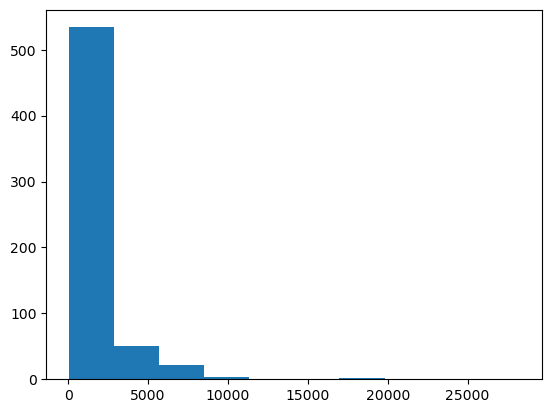

In [28]:
plt.hist(tiles_sv['EFFTIME_SPEC'])

In [29]:
tiles_sv

TILEID,SURVEY,PROGRAM,FAPRGRM,FAFLAVOR,NEXP,EXPTIME,TILERA,TILEDEC,EFFTIME_ETC,EFFTIME_SPEC,EFFTIME_GFA,GOALTIME,OBSSTATUS,LRG_EFFTIME_DARK,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GOALTYPE,MINTFRAC,LASTNIGHT,RA,DEC
int32,bytes20,bytes6,bytes20,bytes20,int64,float64,float64,float64,float64,float64,float64,float64,bytes20,float64,float64,float64,float64,bytes20,float64,int32,float64,float64
80609,sv1,dark,lrgqso,cmxlrgqso,15,13500.7,150.12,2.206,0.0,7828.3,0.0,4000.0,obsstart,7847.0,7828.3,8057.3,10707.3,dark,0.9,20201217,150.12,2.206
80607,sv1,dark,lrgqso,cmxlrgqso,15,13500.8,106.74,56.1,0.0,9374.2,0.0,4000.0,obsstart,8794.6,9374.2,8553.9,8541.1,dark,0.9,20201219,106.74,56.1
80606,sv1,dark,elg,cmxelg,12,10800.7,36.448,-4.501,0.0,6699.4,0.0,4000.0,obsstart,6555.6,6699.4,6583.6,7397.5,dark,0.9,20201219,36.448,-4.501
80620,sv1,dark,lrgqso,sv1lrgqso,9,8100.5,144.0,65.0,0.0,7128.7,0.0,4000.0,obsstart,6643.9,7128.7,6299.8,6316.1,dark,0.9,20201221,144.0,65.0
80622,sv1,dark,lrgqso,sv1lrgqso,6,5400.3,155.0,32.325,0.0,4916.9,0.0,4000.0,obsstart,4772.1,4916.9,4739.8,6935.4,dark,0.9,20201221,155.0,32.325
80623,sv1,dark,elg,sv1elg,8,7200.4,155.0,32.425,0.0,4969.7,0.0,4000.0,obsstart,4903.1,4969.7,4916.9,7266.2,dark,0.9,20201221,155.0,32.425
80611,sv1,bright,bgsmws,sv1bgsmws,12,3600.9,35.22,30.3,0.0,669.2,0.0,600.0,obsstart,641.1,723.7,669.2,407.7,bright,0.9,20201222,35.22,30.3
80617,sv1,bright,bgsmws,sv1bgsmws,16,4801.0,5.0,28.0,0.0,1309.5,0.0,600.0,obsstart,1251.7,1369.7,1309.5,884.1,bright,0.9,20201223,5.0,28.0
80608,sv1,dark,elg,cmxelg,23,20701.4,106.74,56.2,0.0,15166.0,0.0,4000.0,obsstart,14236.7,15166.0,13797.6,14267.9,dark,0.9,20201223,106.74,56.2


In [30]:
tiles_high_efftime

TILEID,SURVEY,PROGRAM,FAPRGRM,FAFLAVOR,NEXP,EXPTIME,TILERA,TILEDEC,EFFTIME_ETC,EFFTIME_SPEC,EFFTIME_GFA,GOALTIME,OBSSTATUS,LRG_EFFTIME_DARK,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GOALTYPE,MINTFRAC,LASTNIGHT,RA,DEC
int32,bytes20,bytes6,bytes20,bytes20,int64,float64,float64,float64,float64,float64,float64,float64,bytes20,float64,float64,float64,float64,bytes20,float64,int32,float64,float64
80605,sv1,dark,lrgqso,cmxlrgqso,24,19559.1,36.448,-4.601,0.0,6872.9,0.0,4000.0,obsstart,6711.4,6872.9,6890.6,6824.3,dark,0.9,20210205,36.448,-4.601
80606,sv1,dark,elg,cmxelg,12,10800.7,36.448,-4.501,0.0,6699.4,0.0,4000.0,obsstart,6555.6,6699.4,6583.6,7397.5,dark,0.9,20201219,36.448,-4.501
80607,sv1,dark,lrgqso,cmxlrgqso,15,13500.8,106.74,56.1,0.0,9374.2,0.0,4000.0,obsstart,8794.6,9374.2,8553.9,8541.1,dark,0.9,20201219,106.74,56.1
80608,sv1,dark,elg,cmxelg,23,20701.4,106.74,56.2,0.0,15166.0,0.0,4000.0,obsstart,14236.7,15166.0,13797.6,14267.9,dark,0.9,20201223,106.74,56.2
80609,sv1,dark,lrgqso,cmxlrgqso,15,13500.7,150.12,2.206,0.0,7828.3,0.0,4000.0,obsstart,7847.0,7828.3,8057.3,10707.3,dark,0.9,20201217,150.12,2.206
80610,sv1,dark,elg,cmxelg,16,13955.7,150.12,2.306,0.0,9523.2,0.0,4000.0,obsend,9378.1,9523.2,9373.5,10559.9,dark,0.9,20210208,150.12,2.306
80612,sv1,bright,bgsmws,sv1bgsmws,17,5101.3,66.68,-5.24,0.0,1458.8,0.0,600.0,obsstart,1417.1,1535.0,1458.8,794.9,bright,0.9,20201223,66.68,-5.24
80613,sv1,bright,bgsmws,sv1bgsmws,30,10975.0,106.74,56.1,0.0,3049.3,0.0,600.0,obsend,2967.4,3359.9,3049.3,2016.8,bright,0.9,20210324,106.74,56.1
80616,sv1,bright,bgsmws,sv1bgsmws,17,5101.1,356.0,29.0,0.0,1538.8,0.0,600.0,obsend,1501.8,1686.3,1538.8,773.8,bright,0.9,20201223,356.0,29.0


In [31]:
fba_path = "/global/cfs/cdirs/desi/target/fiberassign/tiles/trunk/" 
for tileh in tiles_high_efftime:
    tileid = tileh['TILEID']
    fba_file = os.path.join(fba_path, '{:03d}'.format(tileid//1000), 'fiberassign-{:06d}.fits.gz'.format(tileid))
    print(fba_file)
    d = Table(fitsio.read(fba_file, "FIBERASSIGN"))
    in_dark = np.isin(d['TARGETID'], main_dark['TARGETID'])
    in_bright = np.isin(d['TARGETID'], main_bright['TARGETID'])
    in_main = np.count_nonzero(in_dark|in_bright)
    print(tileid, in_main, tileh['FAPRGRM'])

/global/cfs/cdirs/desi/target/fiberassign/tiles/trunk/080/fiberassign-080605.fits.gz
80605 2043 lrgqso
/global/cfs/cdirs/desi/target/fiberassign/tiles/trunk/080/fiberassign-080606.fits.gz
80606 1638 elg
/global/cfs/cdirs/desi/target/fiberassign/tiles/trunk/080/fiberassign-080607.fits.gz
80607 1854 lrgqso
/global/cfs/cdirs/desi/target/fiberassign/tiles/trunk/080/fiberassign-080608.fits.gz
80608 1428 elg
/global/cfs/cdirs/desi/target/fiberassign/tiles/trunk/080/fiberassign-080609.fits.gz
80609 1956 lrgqso
/global/cfs/cdirs/desi/target/fiberassign/tiles/trunk/080/fiberassign-080610.fits.gz
80610 1657 elg
/global/cfs/cdirs/desi/target/fiberassign/tiles/trunk/080/fiberassign-080612.fits.gz
80612 2893 bgsmws
/global/cfs/cdirs/desi/target/fiberassign/tiles/trunk/080/fiberassign-080613.fits.gz
80613 2907 bgsmws
/global/cfs/cdirs/desi/target/fiberassign/tiles/trunk/080/fiberassign-080616.fits.gz
80616 2720 bgsmws
/global/cfs/cdirs/desi/target/fiberassign/tiles/trunk/080/fiberassign-080617.fits.

In [32]:
d['TARGETID']

39633252301931751
39633252301933320
39633252306125282
39633256173274124
39633256173275456
39633256169081219
39633256173273478
39633256173273190
39633252301932354
39633252301933468
616094008476696779
